## Fine-tune SegFormer on a custom dataset

In this notebook, we are going to fine-tune [SegFormerForSemanticSegmentation](https://huggingface.co/docs/transformers/main/model_doc/segformer#transformers.SegformerForSemanticSegmentation) on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [1]:
!pip install -q transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 8.4 MB/s eta 0:00:00


## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [2]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Note that this dataset is now also available on the hub :) you can directly check out the images [in your browser](scene_parse_150)! It can be easily loaded as follows (note that loading will take some time as the dataset is several GB's large):

In [3]:
from datasets import load_dataset

load_entire_dataset = True

if load_entire_dataset:
  dataset = load_dataset("scene_parse_150", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [4]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the image processor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [5]:
from transformers import SegformerImageProcessor

root_dir = '/content/ADE20k_toy_dataset'
image_processor = SegformerImageProcessor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [6]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [7]:
encoded_inputs = train_dataset[0]

In [8]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [9]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [10]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [11]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Next, we define corresponding dataloaders.

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [13]:
batch = next(iter(train_dataloader))

In [14]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [15]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [16]:
mask = (batch["labels"] != 255)
mask

tensor([[[False, False, False,  ..., False, False, False],
         [False,  True,  True,  ...,  True, False, False],
         [False,  True,  True,  ...,  True, False, False],
         ...,
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]],

        [[False,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [False, False,  True,  ...,  True, False, False],
         [False, False,  True,  ...,  True, False, False],
         [False, False, False,  ..., False, False, False]]])

In [17]:
batch["labels"][mask]

tensor([0, 0, 0,  ..., 3, 3, 3])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [18]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

ade20k-id2label.json:   0%|          | 0.00/2.81k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [19]:
import evaluate

metric = evaluate.load("mean_iou")

In [20]:
image_processor.do_reduce_labels

True

In [21]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 5.158244609832764
Mean_iou: 0.0
Mean accuracy: 0.0
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.98430871963501
Mean_iou: 0.000720765829941787
Mean accuracy: 0.005860228634621652
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.850017070770264
Mean_iou: 0.0042608474243374175
Mean accuracy: 0.030117658366835602
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.44359827041626
Mean_iou: 0.021318351424925868
Mean accuracy: 0.28479885338178124
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.686676025390625
Mean_iou: 0.011108720501466706
Mean accuracy: 0.2877209865263864
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.448189735412598
Mean_iou: 0.033279072650376273
Mean accuracy: 0.23123503236061196
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.3384904861450195
Mean_iou: 0.037344887530288313
Mean accuracy: 0.35583062889893413
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.069937705993652
Mean_iou: 0.07052288261218284
Mean accuracy: 0.39300128208328644
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.237856864929199
Mean_iou: 0.04841973484212757
Mean accuracy: 0.3772341095392952
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.7736213207244873
Mean_iou: 0.13246987493524062
Mean accuracy: 0.550861643988685
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.3395776748657227
Mean_iou: 0.13528528058984055
Mean accuracy: 0.34317155162634255
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.7712209224700928
Mean_iou: 0.1583025329554913
Mean accuracy: 0.46065953605117976
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.587008476257324
Mean_iou: 0.11823031964953494
Mean accuracy: 0.25320863609500066
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.417459011077881
Mean_iou: 0.19581533701045534
Mean accuracy: 0.3900453511208292
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6571850776672363
Mean_iou: 0.471750659160769
Mean accuracy: 0.8033488678718282
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.2605080604553223
Mean_iou: 0.17195821700357633
Mean accuracy: 0.3219103137620068
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.9483771324157715
Mean_iou: 0.08621017627188453
Mean accuracy: 0.1564671212710086
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.090301036834717
Mean_iou: 0.13368197397416123
Mean accuracy: 0.2343548264391021
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.135023832321167
Mean_iou: 0.24802381761005413
Mean accuracy: 0.3239251787838204
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.941896915435791
Mean_iou: 0.16554129858696842
Mean accuracy: 0.2618733943448935
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.825674533843994
Mean_iou: 0.17006769276319786
Mean accuracy: 0.2572943476413033
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.5918424129486084
Mean_iou: 0.22039622972475875
Mean accuracy: 0.3551945394520825
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.429269790649414
Mean_iou: 0.18189440029736872
Mean accuracy: 0.34924337938241207
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.4091479778289795
Mean_iou: 0.2324220098212974
Mean accuracy: 0.3569188740664142
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.848926544189453
Mean_iou: 0.344046993654492
Mean accuracy: 0.7023186706172019
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0669660568237305
Mean_iou: 0.2964557131993626
Mean accuracy: 0.5345657931046655
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.4572527408599854
Mean_iou: 0.17955816237845734
Mean accuracy: 0.3270421068189734
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.150371789932251
Mean_iou: 0.19020626690278022
Mean accuracy: 0.36448583071728036
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.3664908409118652
Mean_iou: 0.3402806366488319
Mean accuracy: 0.46098474256256994
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8586246967315674
Mean_iou: 0.29587799027032513
Mean accuracy: 0.44492871442720516
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.5213522911071777
Mean_iou: 0.3313815702594267
Mean accuracy: 0.5254240789863082
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.852158784866333
Mean_iou: 0.15054431384677877
Mean accuracy: 0.26432868413862337
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9452171325683594
Mean_iou: 0.25443055197889236
Mean accuracy: 0.3633725710284785
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9311814308166504
Mean_iou: 0.19435971922261194
Mean accuracy: 0.28650332933830597
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9828685522079468
Mean_iou: 0.3693961956604509
Mean accuracy: 0.4873325698379727
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9253782033920288
Mean_iou: 0.33460875695947906
Mean accuracy: 0.6068330510998203
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7710788249969482
Mean_iou: 0.3010906215813064
Mean accuracy: 0.47164041346011637
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.5755391120910645
Mean_iou: 0.242787428643777
Mean accuracy: 0.4869883226490788
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9068536758422852
Mean_iou: 0.3935349691876859
Mean accuracy: 0.6106331066070728
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8863483667373657
Mean_iou: 0.26769487381199714
Mean accuracy: 0.39893391161633424
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9756160974502563
Mean_iou: 0.13780549410362278
Mean accuracy: 0.19004219471473383
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6614831686019897
Mean_iou: 0.18729059703314402
Mean accuracy: 0.3244263317766417
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7678714990615845
Mean_iou: 0.19057999382731985
Mean accuracy: 0.29043783668653234
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5554044246673584
Mean_iou: 0.21538801948977748
Mean accuracy: 0.37162656420138174
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5710887908935547
Mean_iou: 0.4903895023730555
Mean accuracy: 0.7157646785821501
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5490611791610718
Mean_iou: 0.10133989201783808
Mean accuracy: 0.15880806107129705
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7424103021621704
Mean_iou: 0.4082808061863765
Mean accuracy: 0.5627295357076367
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0500576496124268
Mean_iou: 0.6786099593171357
Mean accuracy: 0.7196211426379885
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9633091688156128
Mean_iou: 0.3810960663192115
Mean accuracy: 0.5173654811378543
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3629330396652222
Mean_iou: 0.22215611480897984
Mean accuracy: 0.3794471991882068
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3284627199172974
Mean_iou: 0.2184113434700048
Mean accuracy: 0.3727749293699378
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3081245422363281
Mean_iou: 0.5463917482316019
Mean accuracy: 0.731520722258444
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7028498649597168
Mean_iou: 0.27291276201934744
Mean accuracy: 0.43171113733631783
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6224299669265747
Mean_iou: 0.1351450099510319
Mean accuracy: 0.22515198040298215
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3392571210861206
Mean_iou: 0.45028255230255915
Mean accuracy: 0.5233620933241464
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2613434791564941
Mean_iou: 0.35060900936501
Mean accuracy: 0.48829970926309463
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2223669290542603
Mean_iou: 0.20878943674541056
Mean accuracy: 0.27792638105762074
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3899976015090942
Mean_iou: 0.20558025147852652
Mean accuracy: 0.3573149836784251
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3917121887207031
Mean_iou: 0.29489628094565423
Mean accuracy: 0.37685979684790866
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.22917640209198
Mean_iou: 0.23980768200396815
Mean accuracy: 0.3101810834851187
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6461282968521118
Mean_iou: 0.19305510854562472
Mean accuracy: 0.29440810939756584
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.425734043121338
Mean_iou: 0.30181637852605425
Mean accuracy: 0.4489186360178208
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9887256026268005
Mean_iou: 0.35288218919848413
Mean accuracy: 0.47335482295629133
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3701016902923584
Mean_iou: 0.3980601026876662
Mean accuracy: 0.4951374418835367
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.190908670425415
Mean_iou: 0.23228036918298903
Mean accuracy: 0.36712736780784944
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1799830198287964
Mean_iou: 0.2803597080112959
Mean accuracy: 0.413305158862965
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2601141929626465
Mean_iou: 0.5906427486290481
Mean accuracy: 0.7721369588758107
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2075414657592773
Mean_iou: 0.2568072202382732
Mean accuracy: 0.3368251482323864
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3197098970413208
Mean_iou: 0.4910927159589862
Mean accuracy: 0.6340533840081258
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7438323497772217
Mean_iou: 0.38827197445982475
Mean accuracy: 0.522326373972478
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9551485180854797
Mean_iou: 0.4845856959904757
Mean accuracy: 0.7451969361118701
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7553247809410095
Mean_iou: 0.3503343520267887
Mean accuracy: 0.6581174186090315
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4242764711380005
Mean_iou: 0.22488662546696836
Mean accuracy: 0.30160608461113964
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0338506698608398
Mean_iou: 0.5895496608974905
Mean accuracy: 0.6477852958845598
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0279158353805542
Mean_iou: 0.3657411042570666
Mean accuracy: 0.6095237996633018
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9973127841949463
Mean_iou: 0.7285402129391926
Mean accuracy: 0.7941521537400316
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.997839093208313
Mean_iou: 0.22830542591695135
Mean accuracy: 0.30511699923557084
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3815218210220337
Mean_iou: 0.4121877590306862
Mean accuracy: 0.5297870194434474
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4995267689228058
Mean_iou: 0.6105090058461453
Mean accuracy: 0.7803999603524594
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9687307476997375
Mean_iou: 0.32697484975686536
Mean accuracy: 0.4864939377030447
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3023096323013306
Mean_iou: 0.14824314039210357
Mean accuracy: 0.2425485267957356
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0110363960266113
Mean_iou: 0.35669136190784834
Mean accuracy: 0.48357618292483084
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6185293197631836
Mean_iou: 0.49605944007637665
Mean accuracy: 0.6617421227933863
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1434699296951294
Mean_iou: 0.3938733305051708
Mean accuracy: 0.5555113636715732
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5062384605407715
Mean_iou: 0.38965542241481566
Mean accuracy: 0.512452329055834
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8601107001304626
Mean_iou: 0.6315508589781738
Mean accuracy: 0.6772473650764806
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2367219924926758
Mean_iou: 0.5316701062188676
Mean accuracy: 0.7048022731173036
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2208762168884277
Mean_iou: 0.3272506869107185
Mean accuracy: 0.43674141241442416
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1635735034942627
Mean_iou: 0.28701731917391876
Mean accuracy: 0.37181426681202817
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2677590847015381
Mean_iou: 0.4228962707956806
Mean accuracy: 0.6989577777511652
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8377969861030579
Mean_iou: 0.2727590702660018
Mean accuracy: 0.3500750654558334
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8269359469413757
Mean_iou: 0.2718719804906486
Mean accuracy: 0.3563012587439575
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5427712798118591
Mean_iou: 0.4381488579581583
Mean accuracy: 0.7268900483354895
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9876983761787415
Mean_iou: 0.3040898906253286
Mean accuracy: 0.6155520935722161
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.47544628381729126
Mean_iou: 0.3699321791259282
Mean accuracy: 0.6401096052254659
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4650069773197174
Mean_iou: 0.3917315273921376
Mean accuracy: 0.6349835085998284
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7516013979911804
Mean_iou: 0.17410509926083859
Mean accuracy: 0.25583800725913874
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7703421711921692
Mean_iou: 0.3170225179399461
Mean accuracy: 0.43760974268343567
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5650654435157776
Mean_iou: 0.5020540592750051
Mean accuracy: 0.6042856526637851
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6365504860877991
Mean_iou: 0.30042193328625355
Mean accuracy: 0.5120003280439103
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7450287342071533
Mean_iou: 0.41115682290288563
Mean accuracy: 0.5044549628246803
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.44242194294929504
Mean_iou: 0.607334107719286
Mean accuracy: 0.6443199835691914
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8064351081848145
Mean_iou: 0.5672028576003437
Mean accuracy: 0.645487855825409
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7344703078269958
Mean_iou: 0.3688057441099744
Mean accuracy: 0.5156174742493989
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6898567080497742
Mean_iou: 0.26660704879426483
Mean accuracy: 0.3605070074851982
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7078922986984253
Mean_iou: 0.26672730460852434
Mean accuracy: 0.34764457397681325
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.743826150894165
Mean_iou: 0.2306432417842161
Mean accuracy: 0.306375154159097
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3591457009315491
Mean_iou: 0.481521050357325
Mean accuracy: 0.5758428616443466
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7313814759254456
Mean_iou: 0.6025498302051836
Mean accuracy: 0.6747942606991061
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.621524453163147
Mean_iou: 0.6892349287217117
Mean accuracy: 0.7355741690693751
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8485901355743408
Mean_iou: 0.17353586848425798
Mean accuracy: 0.2630355634013902
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5016710162162781
Mean_iou: 0.686551719005593
Mean accuracy: 0.801813754491426
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9711315035820007
Mean_iou: 0.18958322585820103
Mean accuracy: 0.2773677227796228
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8378468155860901
Mean_iou: 0.48226725567732
Mean accuracy: 0.5669527073648649
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5621780157089233
Mean_iou: 0.8195495186265344
Mean accuracy: 0.8649007892610836
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7218745946884155
Mean_iou: 0.30548441007250443
Mean accuracy: 0.34794587289512724
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.27812671661376953
Mean_iou: 0.7349067764801784
Mean accuracy: 0.8351793477396097
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.16148491203784943
Mean_iou: 0.5518225099489091
Mean accuracy: 0.7020332939634035
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5637166500091553
Mean_iou: 0.41648298337279305
Mean accuracy: 0.571796363749318
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6185597777366638
Mean_iou: 0.3941877876553727
Mean accuracy: 0.5307858489661967
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.721613347530365
Mean_iou: 0.42108588287111537
Mean accuracy: 0.46822457624365876
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5212553143501282
Mean_iou: 0.5860747475970803
Mean accuracy: 0.6613602123419929
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6599826216697693
Mean_iou: 0.28844255311746997
Mean accuracy: 0.4247466084644169
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5562293529510498
Mean_iou: 0.604925488001444
Mean accuracy: 0.6838663458032008
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7189399600028992
Mean_iou: 0.2363898444450501
Mean accuracy: 0.3365198752757352
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.41324448585510254
Mean_iou: 0.46670888692575796
Mean accuracy: 0.7171812372579554
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6028947830200195
Mean_iou: 0.48575565559183426
Mean accuracy: 0.6583241023870843
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0276490449905396
Mean_iou: 0.33918263167934687
Mean accuracy: 0.47072848883127494
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5321147441864014
Mean_iou: 0.6933179147464472
Mean accuracy: 0.7431470975420085
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5889116525650024
Mean_iou: 0.44219256602745244
Mean accuracy: 0.5109275629440576
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5187764167785645
Mean_iou: 0.6582976643449835
Mean accuracy: 0.6862324945428011
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6375558376312256
Mean_iou: 0.29914447907271713
Mean accuracy: 0.38151765564828977
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1695781648159027
Mean_iou: 0.8372282715542692
Mean accuracy: 0.8581456182631003
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4986090660095215
Mean_iou: 0.6012144816708554
Mean accuracy: 0.6744276037742077
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5114477872848511
Mean_iou: 0.6494000166221141
Mean accuracy: 0.6753091532612717
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.43668392300605774
Mean_iou: 0.557491551177349
Mean accuracy: 0.5835813002228438
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1294717788696289
Mean_iou: 0.5576277678616933
Mean accuracy: 0.7085777239360115
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.17669548094272614
Mean_iou: 0.8354358835639746
Mean accuracy: 0.8487771563049598
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2948022782802582
Mean_iou: 0.7174614155536604
Mean accuracy: 0.8145274548162464
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4586404263973236
Mean_iou: 0.4248948490716543
Mean accuracy: 0.552041235579138
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22608640789985657
Mean_iou: 0.7402015802839967
Mean accuracy: 0.8429215210669833
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5761677026748657
Mean_iou: 0.5742435084486229
Mean accuracy: 0.6306255020212188
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.47766274213790894
Mean_iou: 0.6858029800000297
Mean accuracy: 0.7380976275994703
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3538413941860199
Mean_iou: 0.4375398136713857
Mean accuracy: 0.6077534543576139
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.614711582660675
Mean_iou: 0.48508265201950485
Mean accuracy: 0.5343275581250869
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5579823851585388
Mean_iou: 0.5636075047884048
Mean accuracy: 0.6595595321642499
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.173444926738739
Mean_iou: 0.9338859608912657
Mean accuracy: 0.9540449091978518
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2450931817293167
Mean_iou: 0.5390675176784333
Mean accuracy: 0.734627922419682
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.42532455921173096
Mean_iou: 0.6538217116015753
Mean accuracy: 0.6931058199345064
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2910183072090149
Mean_iou: 0.6586668054653425
Mean accuracy: 0.6892478234008759
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5344407558441162
Mean_iou: 0.5581233353667988
Mean accuracy: 0.6421548417365593
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6021055579185486
Mean_iou: 0.303985478049575
Mean accuracy: 0.3335161822925332
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.38453975319862366
Mean_iou: 0.8823919238757063
Mean accuracy: 0.9093483551646203
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3393414318561554
Mean_iou: 0.4711405593059548
Mean accuracy: 0.6364871896752505
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4018804430961609
Mean_iou: 0.5492111509448031
Mean accuracy: 0.6486380661224503
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2709912955760956
Mean_iou: 0.48256522597385304
Mean accuracy: 0.6197442691784605
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5714337825775146
Mean_iou: 0.48886746572686596
Mean accuracy: 0.5365989404476705
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5748206973075867
Mean_iou: 0.5140009236383395
Mean accuracy: 0.552976088104831
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6180201172828674
Mean_iou: 0.36777242167857227
Mean accuracy: 0.4077791465373658
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.577315628528595
Mean_iou: 0.453627589720824
Mean accuracy: 0.5781572972572764
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5153086185455322
Mean_iou: 0.48100529316978247
Mean accuracy: 0.5665801833984716
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12132861465215683
Mean_iou: 0.8462228425473962
Mean accuracy: 0.8629080772712725
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.29642942547798157
Mean_iou: 0.446175050562267
Mean accuracy: 0.6137345353867855
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.42402738332748413
Mean_iou: 0.3302131101228854
Mean accuracy: 0.44108292575519537
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4810154438018799
Mean_iou: 0.5381802028409567
Mean accuracy: 0.5874706865763905
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5098781585693359
Mean_iou: 0.5953563363890217
Mean accuracy: 0.668298191477612
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4145430326461792
Mean_iou: 0.6057566105446103
Mean accuracy: 0.6542667678061987
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11303902417421341
Mean_iou: 0.8479175745081452
Mean accuracy: 0.8617109619654292
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.32170334458351135
Mean_iou: 0.6970434085192567
Mean accuracy: 0.8074140342907475
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4279434084892273
Mean_iou: 0.5948676644510903
Mean accuracy: 0.6494147985849775
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.434917688369751
Mean_iou: 0.3293842960410004
Mean accuracy: 0.44203884598727716
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24976785480976105
Mean_iou: 0.6712636110325975
Mean accuracy: 0.7005066752236541
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.33797967433929443
Mean_iou: 0.4498732153148727
Mean accuracy: 0.6075986699987884
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.32498112320899963
Mean_iou: 0.6023596847429135
Mean accuracy: 0.6612345088133991
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.19552676379680634
Mean_iou: 0.5045066919797024
Mean accuracy: 0.7781784957967506
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49563005566596985
Mean_iou: 0.5490536367487923
Mean accuracy: 0.5859764919160703
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.48266133666038513
Mean_iou: 0.21519292005538654
Mean accuracy: 0.2812394447972393
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3972565531730652
Mean_iou: 0.5714487373568264
Mean accuracy: 0.6125555468581845
Epoch: 178


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3564659655094147
Mean_iou: 0.800587345435336
Mean accuracy: 0.8212428411428669
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11487852782011032
Mean_iou: 0.8457472070923346
Mean accuracy: 0.8593389966379236
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1857856959104538
Mean_iou: 0.5409800649504196
Mean accuracy: 0.6259212751609078
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.48725858330726624
Mean_iou: 0.4729755134046223
Mean accuracy: 0.5821183937887003
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3560267686843872
Mean_iou: 0.24024841152385445
Mean accuracy: 0.35890646601495535
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5725862383842468
Mean_iou: 0.36920162088523434
Mean accuracy: 0.41462261640601245
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.20496869087219238
Mean_iou: 0.6930127605677641
Mean accuracy: 0.7206925053645981
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.21721798181533813
Mean_iou: 0.8606701166118135
Mean accuracy: 0.8872856473423709
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36007213592529297
Mean_iou: 0.8006577915360522
Mean accuracy: 0.8233947590621224
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24274249374866486
Mean_iou: 0.49058819354587657
Mean accuracy: 0.757243325921627
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4683676064014435
Mean_iou: 0.4239722916467752
Mean accuracy: 0.4609796949228202
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.39751532673835754
Mean_iou: 0.47906708232022605
Mean accuracy: 0.5949111382832328
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4269278943538666
Mean_iou: 0.623146512185406
Mean accuracy: 0.6600057954885511
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2319779396057129
Mean_iou: 0.9297940366945726
Mean accuracy: 0.9557646084630712
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3635817766189575
Mean_iou: 0.5848165157366234
Mean accuracy: 0.6317155298848898
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4467603862285614
Mean_iou: 0.28005733067263394
Mean accuracy: 0.39189002325272465
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.29483234882354736
Mean_iou: 0.6572428001360008
Mean accuracy: 0.7282784780564211
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36896148324012756
Mean_iou: 0.6769373240230159
Mean accuracy: 0.7038614316020961
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2252849042415619
Mean_iou: 0.5245284365825024
Mean accuracy: 0.7545477361161158
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4363023340702057
Mean_iou: 0.5252721523853231
Mean accuracy: 0.580039549108065
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.26024481654167175
Mean_iou: 0.7133005136225999
Mean accuracy: 0.7378001065138954
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4077607989311218
Mean_iou: 0.3066505591036226
Mean accuracy: 0.3976348546723239


## Inference

Finally, let's check whether the model has really learned something.

Let's test the trained model on an image (refer to my [inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb) for details):

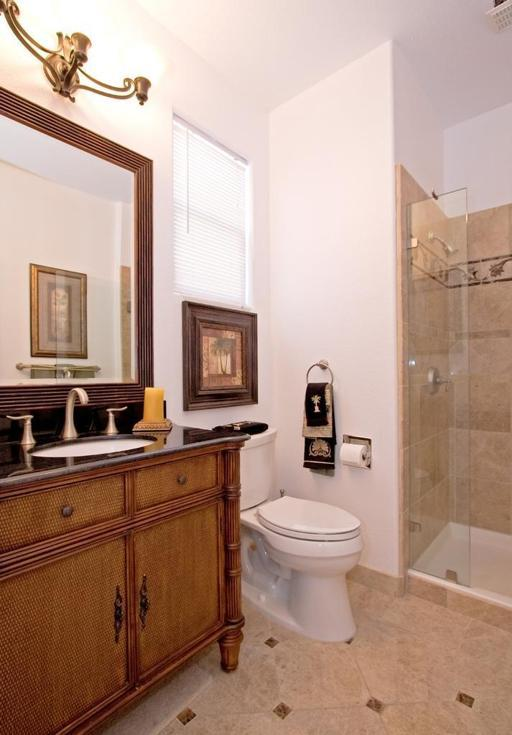

In [51]:
image = Image.open('/content/ADE20k_toy_dataset/images/training/ADE_train_00000007.jpg')
image

In [52]:
# prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [53]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [54]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [55]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [56]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[ 0  0  0 ...  5  5  5]
 [ 0  0  0 ...  5  5  5]
 [ 0  0  0 ...  5  5  5]
 ...
 [10 10 10 ...  3  3  3]
 [10 10 10 ...  3  3  3]
 [10 10 10 ...  3  3  3]]


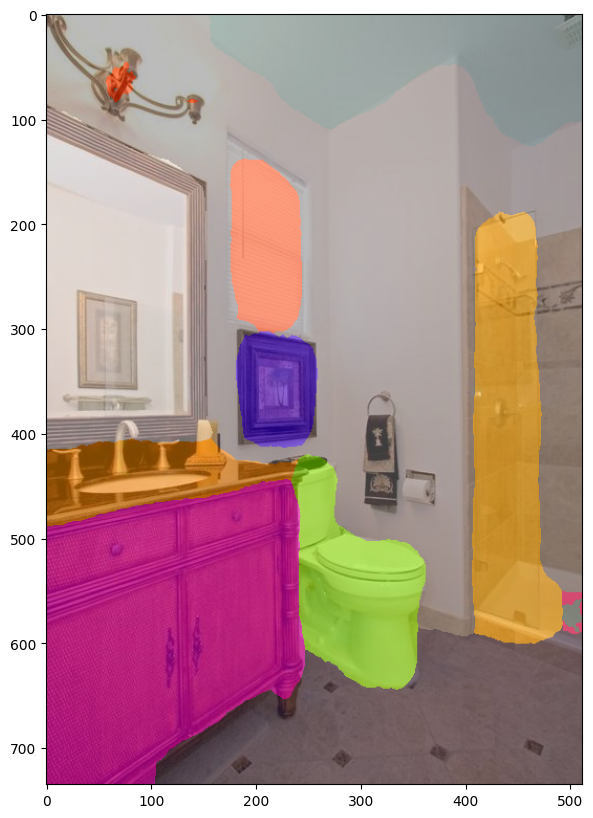

In [57]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth segmentation map:

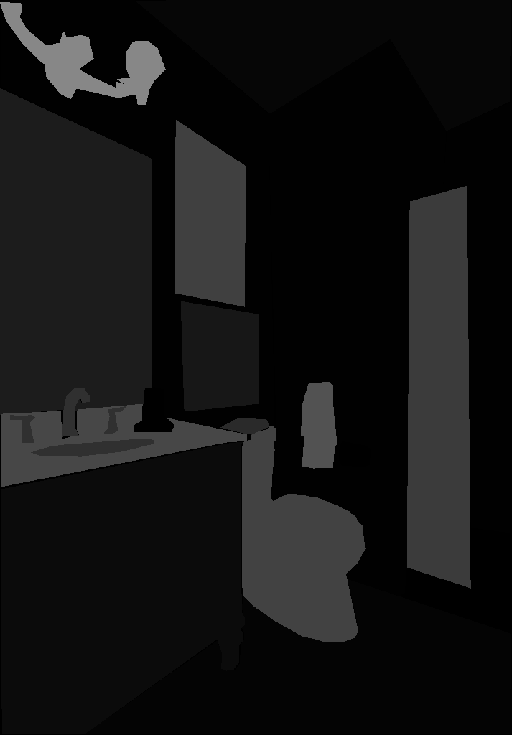

In [58]:
map = Image.open('/content/ADE20k_toy_dataset/annotations/training/ADE_train_00000007.png')
map

Classes in this image: ['wall', 'floor', 'ceiling', 'cabinet', 'painting', 'mirror', 'box', 'sink', 'screen door', 'blind', 'toilet', 'countertop', 'towel', 'sconce', None]


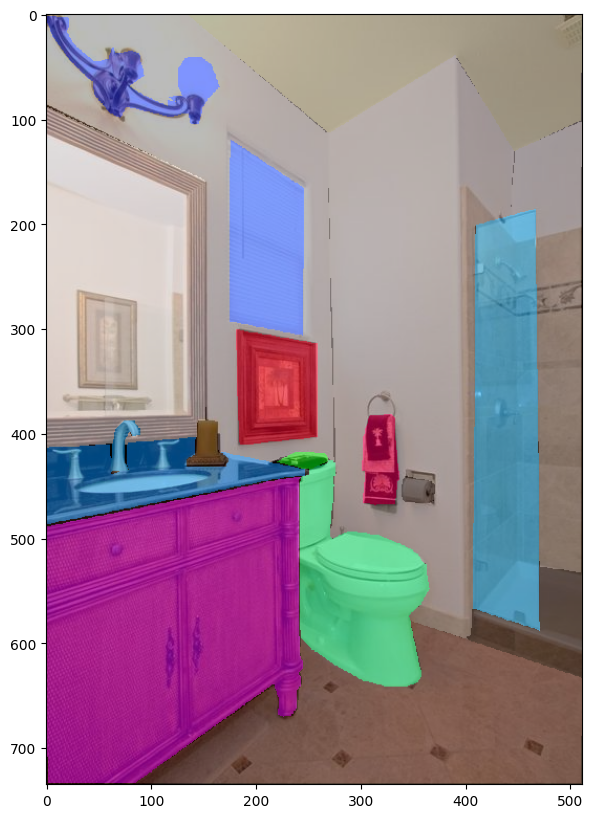

In [59]:
# convert map to NumPy array
import cv2
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = cv2.resize(color_seg, (img.shape[1], img.shape[0]))

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Let's compute the metrics:

In [60]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric._compute(
                  predictions=[predicted_segmentation_map],
                  references=[map],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


In [61]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [62]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.6668087485554891
mean_accuracy 0.7012977485407725
overall_accuracy 0.950144320514894
---------------------
per-category metrics:


IoU  accuracy
wall      0.897145  0.981681
building       NaN       NaN
sky            NaN       NaN
floor     0.959651  0.981590
tree           NaN       NaN
...            ...       ...
shower         NaN       NaN
radiator       NaN       NaN
glass          NaN       NaN
clock          NaN       NaN
flag           NaN       NaN

[150 rows x 2 columns]

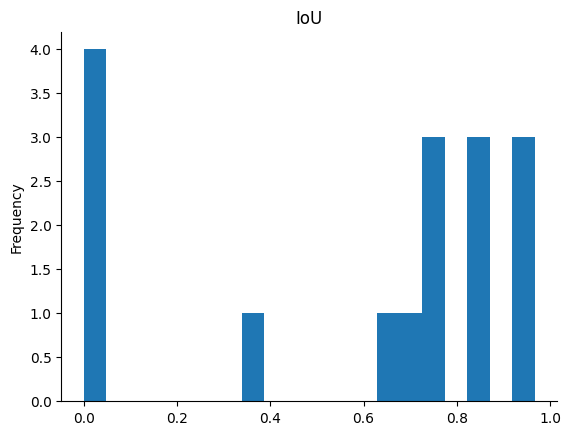

In [38]:
from matplotlib import pyplot as plt
_df_0['IoU'].plot(kind='hist', bins=20, title='IoU')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [37]:
metric_table

{'wall': [0.838801233341504, 0.9374125924537551],
 'building': [nan, nan],
 'sky': [nan, nan],
 'floor': [0.9670876747340279, 0.9843827308275477],
 'tree': [nan, nan],
 'ceiling': [0.9337162305892364, 0.9720309143654361],
 'road': [nan, nan],
 'bed ': [nan, nan],
 'windowpane': [0.9190287848824434, 0.9544728434504792],
 'grass': [nan, nan],
 'cabinet': [nan, nan],
 'sidewalk': [nan, nan],
 'person': [0.7026643107092125, 0.900977343402932],
 'earth': [nan, nan],
 'door': [0.374609375, 0.40226510067114096],
 'table': [nan, nan],
 'mountain': [nan, nan],
 'plant': [0.7634011090573013, 0.8785157173245096],
 'curtain': [nan, nan],
 'chair': [0.6663141661158846, 0.727929142196977],
 'car': [nan, nan],
 'water': [nan, nan],
 'painting': [nan, nan],
 'sofa': [nan, nan],
 'shelf': [nan, nan],
 'house': [nan, nan],
 'sea': [nan, nan],
 'mirror': [nan, nan],
 'rug': [nan, nan],
 'field': [nan, nan],
 'armchair': [nan, nan],
 'seat': [nan, nan],
 'fence': [nan, nan],
 'desk': [nan, nan],
 'rock': 